# Plots
> Plotting is everything!

Here we provide the code to process the results as they come from the examples in the benchmarking and transfer learning notebooks. The plots have the same format as the ones in the paper.

In [ ]:
from bounce.hamiltonian import XXHamiltonian
from bounce.utils import save_benchmark, load_benchmark
from bounce.utils import best_so_far, arrange_shape, state2str

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from pathlib import Path
import pickle
%matplotlib inline

## Benchmark plots

In the paper we compare the performance of different methods. Here we provide the source code to reproduce the plots (Figure 5). 

In [ ]:
def load_benchmark_plot_data(suffix, **kwargs):
    "Loads the data required for the plotting."
    name = f"bench_plot_data_{suffix}.pkl"
    bench_path = Path("../benchmarks/")/name
    if bench_path.exists():
        with open(bench_path, 'rb') as f:
            plot_data = pickle.load(f)
    else:
        plot_data = process_benchmark_data(suffix, **kwargs)
    return plot_data
    
def process_benchmark_data(suffix, max_trains=50, algorithms=['DQN', 'MC', 'BFS'], save_path=None):
    "Processes the benchmark data for the plots."
    results = {algorithm: {} for algorithm in algorithms}
    for N in range(5, 17):
        B, J = [1]*N, [i%3 for i in range(N)]
        H = XXHamiltonian(N, B, J)

        for algorithm in algorithms:
            try: 
                benchmark = load_benchmark(N, H, algorithm, suffix=suffix)
                if algorithm == 'DQN': 
                    rewards = best_so_far(arrange_shape(benchmark['exploration']['oracle_rewards'][:max_trains]))
                else: 
                    rewards = best_so_far(arrange_shape(benchmark['oracle_rewards'][:max_trains]))
                best_mean = np.mean(rewards, axis=0)
                best_std = np.std(rewards, axis=0)
                try:    over95 = np.where(best_mean >= 0.95)[0][0]
                except: over95 = np.inf
                results[algorithm][N] = (best_mean, best_std, over95)
            except:
                pass
            
    if save_path is None: save_path = Path(f"../benchmarks/bench_plot_data_{suffix}.pkl")
    with open(save_path, 'wb') as f:
        pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)
    return results

In [ ]:
def plot_benchmark(results, suffix, ylim=(0, 2300), lw=3.5, ms=10, fs=18, ts=16, n_max=16):
    linestyles = ['-', ':', '--']
    markers = ['s', 'o', 'h']
    fig = plt.figure(figsize=(12, 5))
    
    for a, alg in enumerate(results.keys()):
        plot_vline = False
        ns, times = [], []
        for n, (_, _, over95) in results[alg].items(): ns.append(n); times.append(over95)
        if times[-1] == np.inf:  ns.pop(-1); times.pop(-1); plot_vline = True
        elif ns[-1] != n_max: plot_vline = True
        label = alg if alg != 'DQN' else 'RL'
        plt.plot(ns, times, linestyle=linestyles[a], linewidth=lw, marker=markers[a], ms=ms, label=label)
        if plot_vline: 
            plt.vlines(ns[-1], 0, ylim[1], linestyles='dashed', alpha=0.7)
            plt.text(ns[-1], 0.93*ylim[1], r"$\rightarrow$ Not found", fontsize=fs)
            
    plt.grid(alpha=0.5)
    plt.legend(fontsize=ts, loc="upper left")
    plt.xlabel("System size", fontsize=fs)
    plt.ylabel("States to 95% optimality", fontsize=ts)
    plt.tick_params(labelsize=ts)
    plt.savefig(Path(f"../figures/benchmark_sizes_{suffix}.pdf"), bbox_inches='tight')

In [ ]:
suffix = 'half_3'
results_half = load_benchmark_plot_data(suffix)

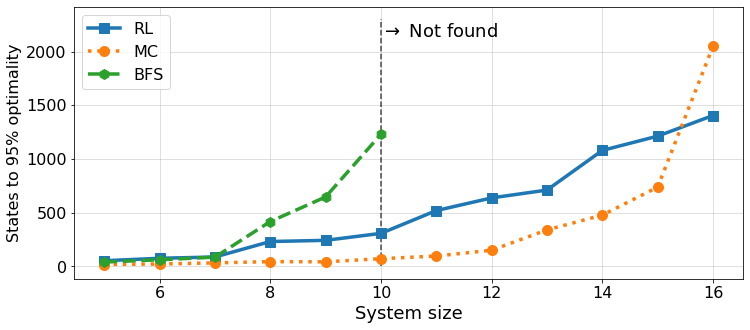

In [ ]:
plot_benchmark(results_half, suffix)

In [ ]:
suffix = 'all_3'
results_all = load_benchmark_plot_data(suffix)

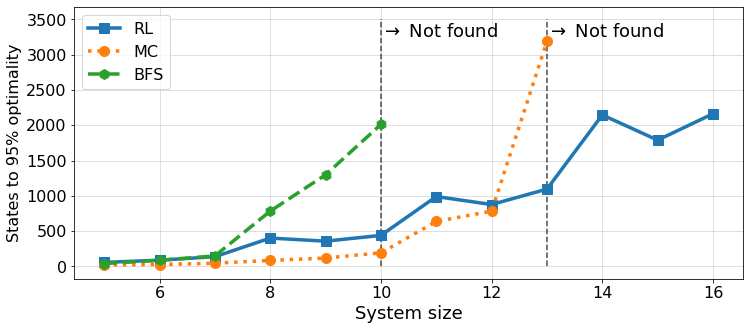

In [ ]:
plot_benchmark(results_all, suffix, ylim=(0, 3500))

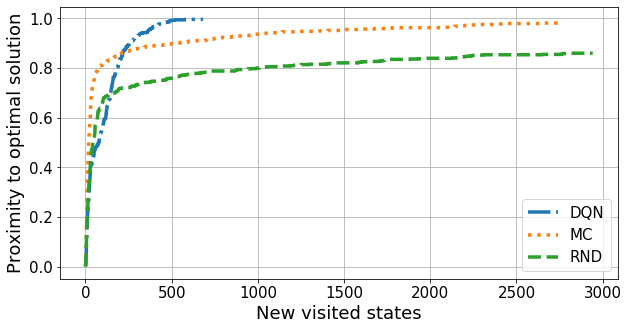

In [ ]:
n = 11 

linestyles = ['-.', ':', '--']
linewidth = 3.5
fs = 18
ticksize = 15
plt.figure(figsize=(10, 5))
for a, algorithm in enumerate(algorithms):
    plt.plot(results[algorithm][n][0], linestyle=linestyles[a], linewidth=linewidth, label=algorithm)
plt.grid()
plt.legend(fontsize=ticksize)
plt.tick_params(labelsize=ticksize)
plt.xlabel("New visited states", fontsize=fs)
plt.ylabel("Proximity to optimal solution", fontsize=fs);

## Transfer learning across phases

We analyse the effect of transfer learning across different phases of the same Hamiltonian. Here we provide the source code to reproduce the plots (Figure 6).

In [ ]:
N = 6
max_limit = 185
B0 = 5
path = Path(f"../benchmarks/TL_N{N}_{max_limit}_from_B{B0}.pkl")
with open(path, 'rb') as f:
    TL_evaluation = pickle.load(f)

In [ ]:
def convergence_time(results, tol=5e-4, T=50, t_avg=20, return_diffs=False):
    "Returns the convergence with criterion of not changing result by `tol` for `T` epochs."
    if 'training' in results.keys(): results = results['training']
    rewards = arrange_shape(results['rewards'])
    mean_rewards = np.mean(rewards, axis=0)
    epochs = len(mean_rewards)
    moving_avg = np.convolve(np.array([1/t_avg]*t_avg), mean_rewards, mode='valid')
    diffs = np.abs(moving_avg[1:] - moving_avg[:-1])
    diff_variation = np.convolve(np.array([1/T]*T), diffs, mode='valid')
    try:    t = np.where(diff_variation <= tol)[0][0]
    except: t = len(mean_rewards)
    if return_diffs: return t + 2*T, moving_avg, diff_variation 
    return t + T

def indiv_convergence_time(results, max_epochs=800, **kwargs):
    "Similar to `convergence_time` but with each agent."
    results = results['rewards']
    times = [convergence_time({'rewards': [res[:max_epochs]]}, **kwargs) for res in results]
    return np.array(times)

def get_indiv_times(tl_eval, convergence_crit=None):
    "Provides convergence times from individual ratios."
    default_crit = {'T': 50, 't_avg': 100, 'tol': 2e-4}
    convergence_crit = {**default_crit, **convergence_crit} if convergence_crit is not None else default_crit
    Bs = list(TL_evaluation.keys()); Bs.sort()
    time_ratios, time_err = [], []
    for b in Bs:
        ts_tl = indiv_convergence_time(tl_eval[b]['tl'], **convergence_crit)
        ts_0 = indiv_convergence_time(tl_eval[b]['vanilla'], **convergence_crit)
        t0, ttl = ts_0.mean(), ts_tl.mean()
        ratio = ttl/t0
        ratio_std = np.sqrt((1/t0)**2*ts_tl.var() + (ttl/t0**2)**2*ts_0.var())
        time_ratios.append(ratio)
        time_err.append(ratio_std/np.sqrt(len(ts_0)))
    return Bs, np.array(time_ratios), np.array(time_err)

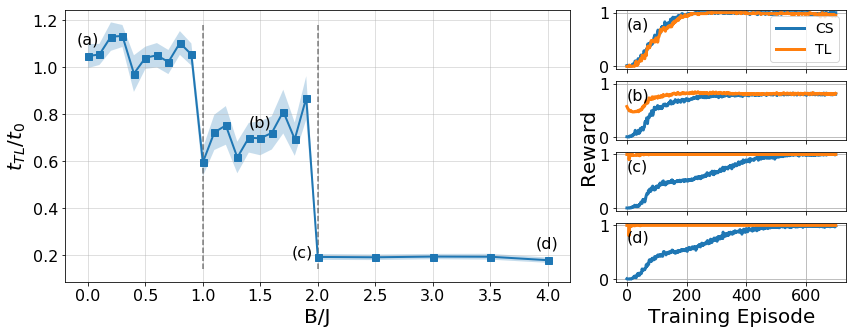

In [ ]:
inset_Bs = [0., 1.5, 2., 4.]
ax_width, ax_length = 0.25, 0.2
max_epochs = 700
refs = ["(a)", "(b)", "(c)", "(d)"]
plot_rewards_tl = [np.mean(TL_evaluation[b]['tl']['rewards'], axis=0)[:max_epochs] for b in inset_Bs]
plot_rewards_cs = [np.mean(TL_evaluation[b]['vanilla']['rewards'], axis=0)[:max_epochs] for b in inset_Bs]

def plot_subplot(ax, tl_rewards, cs_rewards, xlabel=False, legend=False, ref="(a)", ylim=[-0.05, 1.05]):
    ax.plot(cs_rewards, linewidth=3, label="CS")
    ax.plot(tl_rewards, linewidth=3, label="TL")
    ax.tick_params(labelbottom=xlabel)
    ax.text(0.1, 0.7, ref, fontsize=16)
    if xlabel: ax.set_xlabel("Training Episode", fontsize=20)
    if legend: ax.legend(fontsize=14, loc='lower right')
    ax.tick_params(labelsize=16)
    ax.set_ylim(ylim)
    ax.grid()

fig = plt.figure(figsize=(14, 5))
gs0 = gs.GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs0[:-1])

# Times
Bs, time_ratios, time_errs = get_indiv_times(TL_evaluation)

ax1.fill_between(Bs, time_ratios-time_errs, time_ratios+time_errs, alpha=0.25)
ax1.plot(Bs, time_ratios, 's-', ms=7, lw=2)
ax1.tick_params(labelsize=16)
ax1.set_xlabel("B/J", fontsize=20)
ax1.set_ylabel(r"$t_{TL}/t_0$", fontsize=20);
ax1.grid(alpha=0.5)
for b, ref in zip(inset_Bs, refs):
    if b != 2: dx, dy = 0.1, 0.05
    else:      dx, dy = 0.23, 0.
    x, y = b-dx, time_ratios[np.where(np.array(Bs) == b)[0][0]]+dy
    ax1.text(x, y, ref, fontsize=16)
ymin, ymax = ax1.get_ylim()
ax1.vlines(0.75, ymin*1.2, ymax*0.95, linestyles='dashed', alpha=0.5)
ax1.vlines(1, ymin*1.2, ymax*0.95, linestyles='dashed', alpha=0.5)
ax1.vlines(2, ymin*1.2, ymax*0.95, linestyles='dashed', alpha=0.5)
    

# Trainings
gs1 = gs0[-1].subgridspec(4, 1)

axes2 = [fig.add_subplot(gs1[i]) for i in range(4)]
for i, ax in enumerate(axes2): 
    plot_subplot(ax, plot_rewards_tl[i], plot_rewards_cs[i], xlabel=i==3, legend=i==0, ref=refs[i])
fig.text(0.635, 0.5, "Reward", va='center', rotation='vertical', fontsize=20);
plt.savefig(f"../figures/TL_bench_N{N}_{max_limit}_from_B{B0}.pdf", bbox_inches="tight")

## Energy bounds at different system sizes

We also study the energy bounds provided by the same qualitative solutions at different system sizes in Appendix C. With the following code you can obtain the energy bounds along one phase of the XX Hamiltonian for several sets of constraints. 

In [ ]:
def test_configs(confs, N, Bs):
    "Tests a list of configurations for the XX Hamiltonian in the range of Bs (J=1)."
    J = [1]*N
    energies = []
    for b in tqdm(Bs):
        B = [b]*N
        H = XXHamiltonian(N, np.array(B), np.array(J))
        e = SDPEnvironment(N, H, FlatProfile())
        c_energies, c_params, c_layouts = [], [], []
        for c in confs: 
            e.reset()
            e.state[:N] = 1
            e.state[c] = 1
            es, ps, _ = e.get_values()
            c_energies.append(es)
            c_params.append(ps)
            c_layouts.append(e.layout)
        energies.append(c_energies)
    return np.array(energies), np.array(c_params), c_layouts

def plot_tests(energies, params, labels, Bs, figsize=(8, 4), fontsize=16, labelsize=14):
    plt.figure(figsize=figsize)
    for energy, params, label in zip(energies.T, params, labels):
        plt.plot(Bs, energy, label=label+f" ({params})")
    plt.grid()
    plt.legend(fontsize=labelsize)
    plt.xticks(Bs[::2])
    plt.xlabel("B/J", fontsize=fontsize)
    plt.ylabel("Energy bound", fontsize=fontsize)
    plt.tick_params(labelsize=labelsize)
    plt.axvspan(0, 0.75, facecolor='C0', alpha=0.1)
    plt.axvspan(0.75, 1., facecolor='C1', alpha=0.1)
    plt.axvspan(1., 2., facecolor='C2', alpha=0.1)
    plt.axvspan(2., 2.1, facecolor='C3', alpha=0.1);
    
def save_tests(energies, params, layouts, N):
    save_path = Path(f"../benchmarks/test_{N}.pkl")
    with open(save_path, 'wb') as f:
        pickle.dump((energies, params, layouts), f, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_tests(N):
    save_path = Path(f"../benchmarks/test_{N}.pkl")
    with open(save_path, 'rb') as f:
        energies, params, labels = pickle.load(f)
    return energies, params, layouts

In [ ]:
N = 6
confs = [np.arange(0, N, 2)+N,
         np.concatenate((np.array([0]), np.arange(1, N-1, 2)))+N,
#          np.arange(0, N//2, 1)+N, # double overlap
         np.arange(0, N, 3)+N,
         np.arange(0, 1)]
Bs = np.arange(0, 2.2, 0.1)

energies_6, params_6, layouts_6 = test_configs(confs, N, Bs)
save_tests(energies_6, params_6, layouts_6, N)

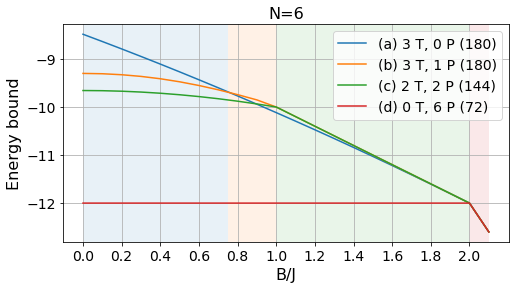

In [ ]:
labels = ['(a) 3 T, 0 P', '(b) 3 T, 1 P', '(c) 2 T, 2 P', '(d) 0 T, 6 P']
plot_tests(energies_6, params_6, labels, Bs)
plt.title("N=6", fontsize=16);
plt.savefig("../figures/pattern_test_N6.pdf", bbox_inches="tight")

In [ ]:
N = 12
confs = [np.arange(0, N, 2)+N,
         np.concatenate((np.array([0]), np.arange(1, N//2-1, 2), np.array([N//2]), np.arange(N//2+1, N-1, 2)))+N,
         np.arange(0, N, 3)+N,
         np.arange(0, 1),
         np.concatenate((np.array([0]), np.arange(1, N-1, 2)))+N,
#          np.sort(np.concatenate((np.arange(0, N, 4), np.arange(1, N, 4))))+N, # tiplet-triplet-pair
#          np.arange(0, N, 4)+N, # triplet-pair-pair
        ]
Bs = np.arange(0, 2.2, 0.1)

energies_12, params_12, layouts_12 = test_configs(confs, N, Bs)
save_tests(energies_12, params_12, layouts_12, N)

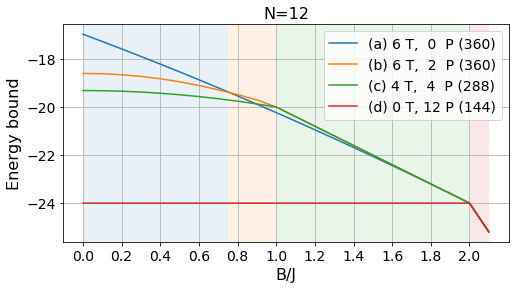

In [ ]:
labels = ['(a) 6 T,  0  P', '(b) 6 T,  2  P', '(c) 4 T,  4  P', '(d) 0 T, 12 P']
plot_tests(energies_12[:, :-1], params_12[:-1], labels, Bs)
plt.title("N=12", fontsize=16);
plt.savefig("../figures/pattern_test_N12.pdf", bbox_inches="tight")

In [ ]:
N = 24
confs = [np.arange(0, N, 2)+N,
         np.concatenate([np.arange(p*(N//4)+1, (p+1)*N//4-1, 2) for p in range(4)] + [np.array([p*N//4]) for p in range(4)])+N,         
         np.arange(0, N, 3)+N,
         np.arange(0, 1),
         np.concatenate([np.arange(p*(N//3)+1, (p+1)*N//3-1, 2) for p in range(3)] + [np.array([p*N//3]) for p in range(3)])+N,
         np.concatenate((np.array([0]), np.arange(1, N//2-1, 2), np.array([N//2]), np.arange(N//2+1, N-1, 2)))+N,
         np.concatenate((np.array([0]), np.arange(1, N-1, 2)))+N,
#          np.sort(np.concatenate((np.arange(0, N, 4), np.arange(1, N, 4))))+N, # tiplet-triplet-pair
#          np.arange(0, N, 4)+N, # triplet-pair-pair
        ]
Bs = np.arange(0, 2.2, 0.1)

energies_24, params_24, layouts_24 = test_configs(confs, N, Bs)
save_tests(energies_24, params_24, layouts_24, N)

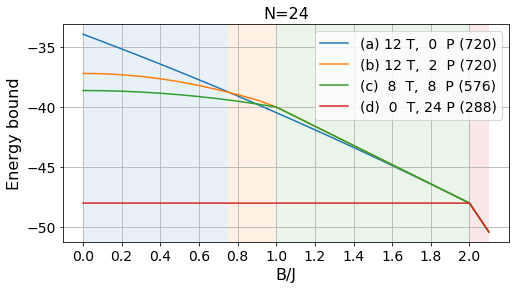

In [ ]:
labels = ['(a) 12 T,  0  P', '(b) 12 T,  4  P', '(c)  8  T,  8  P', '(d)  0  T, 24 P']
plot_tests(energies_24[:, :-3], params_24[:-3], labels, Bs)
plt.title("N=24", fontsize=16);
plt.savefig("../figures/pattern_test_N24.pdf", bbox_inches="tight")

In [ ]:
N = 36
confs = [np.arange(0, N, 2)+N,    
         np.concatenate([np.arange(p*(N//6)+1, (p+1)*N//6-1, 2) for p in range(6)] + [np.array([p*N//6]) for p in range(6)])+N,
         np.arange(0, N, 3)+N,
         np.arange(0, 1),
         np.concatenate([np.arange(p*(N//4)+1, (p+1)*N//4-1, 2) for p in range(4)] + [np.array([p*N//4]) for p in range(4)])+N,
         np.concatenate([np.arange(p*(N//3)+1, (p+1)*N//3-1, 2) for p in range(3)] + [np.array([p*N//3]) for p in range(3)])+N,
         np.concatenate((np.array([0]), np.arange(1, N//2-1, 2), np.array([N//2]), np.arange(N//2+1, N-1, 2)))+N,
         np.concatenate((np.array([0]), np.arange(1, N-1, 2)))+N,
#          np.sort(np.concatenate((np.arange(0, N, 4), np.arange(1, N, 4))))+N, # tiplet-triplet-pair
#          np.arange(0, N, 4)+N, # triplet-pair-pair
        ]
Bs = np.arange(0, 2.2, 0.1)

energies_36, params_36, layouts_36 = test_configs(confs, N, Bs)
save_tests(energies_36, params_36, layouts_36, N)

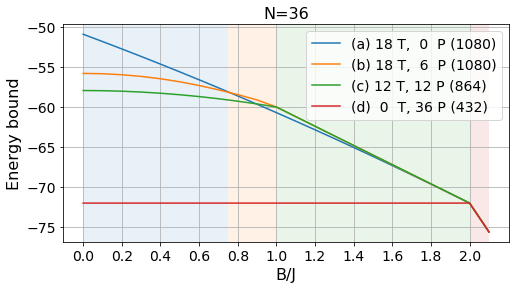

In [ ]:
labels = ['(a) 18 T,  0  P', '(b) 18 T,  6  P', '(c) 12 T, 12 P', '(d)  0  T, 36 P']
plot_tests(energies_36[:, :-3], params_36[:-3], labels, Bs)
plt.title("N=36", fontsize=16);
plt.savefig("../figures/pattern_test_N36.pdf", bbox_inches="tight")